# RQ1 Amazon Spec Visualization
Load per-spec query results for Amazon RQ1 spec scenarios/layouts using the shared parser helpers.


## Selectivity bands
- `S0`: point queries (fan-out K), no ratio range.
- `S1`: range selectivity ∈ [0.0, 0.001).
- `S2`: range selectivity ∈ [0.001, 0.01).
- `S3`: range selectivity ∈ [0.01, 0.1).
- `S4`: range selectivity ∈ [0.1, 0.2).

For RQ1 plotting we usually focus on a specific query prefix (e.g., `Q1_N1_1`, `Q3_K16_1`). Column-config labels (`C*`) simply encode which columns were paired, so we typically pick the first config per query when visualizing layout/scenario effects.

In [1]:
# --- Bootstrap paths so imports work both inside/outside VS Code ---
import sys
from pathlib import Path

NB_DIR = Path.cwd()           # current working dir (likely .../notebooks)
PROJ_ROOT = NB_DIR.parent     # project root (one level up)

for p in (NB_DIR, PROJ_ROOT):
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))

try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    pass

import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from viz_results_toolkit import savefig_multi
from scripts.parse_tpch_results import (
    collect_amazon_rq1_results,
    query_results_dataframe,
    display_query_scenarios,
)

out_dir = PROJ_ROOT / "viz_out_results"
out_dir.mkdir(parents=True, exist_ok=True)


In [28]:
# --- Plotting constants and helper ---

LAYOUT_ORDER = ["no_layout", "linear", "zorder", "hilbert"]

LAYOUT_COLORS = {
    "no_layout": "#1f77b4",
    "linear": "#ff7f0e",
    "zorder": "#2ca02c",
    "hilbert": "#d62728",
}

SCENARIO_ORDER = [
    "SCENARIO_AMAZON_DEFAULT",
    "SCENARIO_AMAZON_DEFAULT_V1",
    "SCENARIO_AMAZON_O2_V1",
    "SCENARIO_AMAZON_O2_V2",
    "SCENARIO_AMAZON_O3_V1",
    "SCENARIO_AMAZON_O3_V2",
]

SCENARIO_DISPLAY = {
    "amazon_default": "Amazon Default",
    "SCENARIO_AMAZON_DEFAULT": "O1-V1",
    "SCENARIO_AMAZON_DEFAULT_V1": "O1-V2",
    "SCENARIO_AMAZON_O2_V1": "O2-V1",
    "SCENARIO_AMAZON_O2_V2": "O2-V2",
    "SCENARIO_AMAZON_O3_V1": "O3-V1",
    "SCENARIO_AMAZON_O3_V2": "O3-V2",
}


LAYOUT_HATCHES = {
    "no_layout": "////",
    "linear": "\\",
    "zorder": "xx",
    "hilbert": "..",
}

LAYOUT_MARKERS = {
    "no_layout": "o",
    "linear": "s",
    "zorder": "^",
    "hilbert": "D",
}

LAYOUT_LINESTYLES = {
    "no_layout": "-",
    "linear": "--",
    "zorder": "-.",
    "hilbert": ":",
}

BLOCK_GAP = 0.8


def plot_scenario_layout_boxes(df, metric, *, scenario_order, layout_order, ax, title):
    cluster_centers = []
    cluster_labels = []
    block_spans = []
    color_handles = []
    seen_layouts = set()
    pos = 1
    for scenario in scenario_order:
        display_label = SCENARIO_DISPLAY.get(scenario, scenario)
        df_s = df[df["scenario_name"] == scenario]
        if df_s.empty:
            continue
        start = pos
        cluster_has_data = False
        for layout in layout_order:
            df_sl = df_s[df_s["layout"] == layout]
            vals = df_sl[metric].dropna().values
            if vals.size == 0:
                continue
            cluster_has_data = True
            box = ax.boxplot(vals, positions=[pos], widths=0.7, patch_artist=True, showfliers=False)
            color = LAYOUT_COLORS.get(layout, "#888888")
            for patch in box['boxes']:
                patch.set_facecolor(color)
                patch.set_alpha(0.6)
            for element in ('caps', 'whiskers', 'medians'):
                for artist in box[element]:
                    artist.set_color(color)
            ax.plot(pos, vals.mean(), marker='o', color=color, markersize=4)
            if layout not in seen_layouts:
                color_handles.append(mpatches.Patch(color=color, label=layout))
                seen_layouts.add(layout)
            pos += 1
        if cluster_has_data:
            end = pos - 1
            cluster_centers.append((start + end) / 2)
            cluster_labels.append(display_label)
            block_spans.append((start, end))
            pos += BLOCK_GAP
    if cluster_centers:
        ax.set_xticks(cluster_centers)
        ax.set_xticklabels(cluster_labels, rotation=15, ha='right')
    ax.set_ylabel(metric)
    for (s, e) in block_spans[:-1]:
        ax.axvline(e + BLOCK_GAP / 2, linestyle='--', color='gray', alpha=0.3)
    ax.set_title(title, pad=16)
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    return color_handles


In [21]:

# --- Helper method to load+plot arbitrary query sets ---
def plot_rq1_amazon_queries(
    queries,
    *,
    selectivity_filter=None,
    column_config_limit=1,
    metric="elapsedTime_s",
    layout_order=None,
    scenario_order=None,
    save=True,
    save_dir=None,
    filename_prefix=None,
    filename=None,
    save_formats=("png", "pdf"),
    legend=True,
    query_aliases=None,
):
    if not queries:
        raise ValueError("Provide at least one query id")
    layout_order = layout_order or LAYOUT_ORDER
    scenario_order = scenario_order or list(SCENARIO_DISPLAY.keys())
    query_aliases = query_aliases or {}
    collection = collect_amazon_rq1_results()
    grouped = {}
    alias_sequence = []
    for query_id in queries:
        df_query = query_results_dataframe(collection, query_id)
        if selectivity_filter:
            df_query = df_query[df_query["selectivity_label"].isin(selectivity_filter)].copy()
        if df_query.empty:
            print(f'[warn] no rows for {query_id} after selectivity filter')
            continue
        features = sorted(df_query["column_config"].unique())
        if column_config_limit:
            features = features[:column_config_limit]
        if not features:
            print(f'[warn] no column configs retained for {query_id}')
            continue
        alias = query_aliases.get(query_id, query_id)
        if alias not in grouped:
            grouped[alias] = {
                'dfs': [],
                'features': set(),
                'scenarios': set(),
                'layouts': set(),
            }
            alias_sequence.append(alias)
        bucket = grouped[alias]
        bucket['dfs'].append(df_query)
        bucket['features'].update(features)
        bucket['scenarios'].update(df_query["scenario_name"].unique())
        bucket['layouts'].update(df_query["layout"].dropna().unique())
    if not grouped:
        raise ValueError('No query produced data; adjust filters')

    summary_frames = []
    plots = []
    for alias in alias_sequence:
        meta = grouped[alias]
        df_alias = pd.concat(meta['dfs'], ignore_index=True)
        features = sorted(meta['features'])
        if column_config_limit:
            features = features[:column_config_limit]
        if not features:
            print(f'[warn] no column configs retained for alias {alias}')
            continue
        feature = features[0]
        df_feat = df_alias[df_alias["column_config"] == feature]
        if df_feat.empty:
            print(f'[warn] no rows for alias {alias} feature {feature}')
            continue
        scenarios_present = meta['scenarios']
        scenario_priority = [name for name in scenario_order if name in scenarios_present]
        if not scenario_priority:
            scenario_priority = sorted(scenarios_present)
        layout_present = meta['layouts']
        layout_priority = [lay for lay in layout_order if lay in layout_present]
        if not layout_priority:
            layout_priority = layout_order
        plots.append((alias, feature, df_feat, scenario_priority, layout_priority))
        summary = (
            df_feat.groupby(["scenario_name", "layout"])
            [["elapsedTime_s", "executorRunTime_s", "bytesRead"]]
            .agg(['count', 'mean', 'median'])
            .round(3)
        )
        summary['query_id'] = alias
        summary['column_config'] = feature
        summary_frames.append(summary)

    if not plots:
        raise ValueError('No query produced data; adjust filters')

    n = len(plots)
    # ncols = max(1, math.ceil(n ** 0.5))
    ncols = 3
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows), squeeze=False)
    legend_handles = []
    seen_labels = set()

    for idx, (alias, feature, df_feat, scenario_priority, layout_priority) in enumerate(plots):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        handles = plot_scenario_layout_boxes(
            df_feat,
            metric,
            scenario_order=scenario_priority,
            layout_order=layout_priority,
            ax=ax,
            title=f"{alias} / {feature} / {selectivity_filter or 'all'}",
        )
        for handle in handles:
            label = handle.get_label()
            if label not in seen_labels:
                legend_handles.append(handle)
                seen_labels.add(label)

    for k in range(len(plots), nrows * ncols):
        r, c = divmod(k, ncols)
        axes[r][c].axis('off')

    if legend and legend_handles:
        legend_obj = fig.legend(
            legend_handles,
            [h.get_label() for h in legend_handles],
            loc='upper center',
            bbox_to_anchor=(0.5, 0.985),
            ncol=len(legend_handles),
            frameon=False,
            handlelength=2.4,
            columnspacing=1.25,
        )
        for patch in legend_obj.legendHandles:
            if hasattr(patch, "set_height"):
                patch.set_height(patch.get_height() * 1.3)
            if hasattr(patch, "set_linewidth"):
                patch.set_linewidth(1.6)
    fig.tight_layout(rect=(0, 0, 1, 0.9))
    if save:
        base_dir = Path(save_dir) if save_dir else out_dir
        base_dir.mkdir(parents=True, exist_ok=True)
        alias_labels = [alias for alias, *_ in plots]
        default_prefix = f"rq1_amazon_{'_'.join(alias_labels)}_{metric}"
        stem_value = filename or filename_prefix or default_prefix
        stem_path = Path(str(stem_value))
        base_name = stem_path.stem if stem_path.suffix else stem_path.name
        fmt_list = [stem_path.suffix.lstrip('.')] if stem_path.suffix else save_formats
        if isinstance(fmt_list, str):
            fmt_list = [fmt_list]
        saved_paths = []
        for fmt in fmt_list:
            ext = fmt.lstrip('.')
            out_path = base_dir / f"{base_name}.{ext}"
            fig.savefig(out_path, bbox_inches="tight", pad_inches=0.02)
            saved_paths.append(out_path)
        print("saved:", ", ".join(str(p) for p in saved_paths))
    summary = pd.concat(summary_frames) if summary_frames else pd.DataFrame()
    return fig, summary



def plot_rq1_amazon_query_groups(query_groups, **kwargs):
    'Plot alias groups by supplying a mapping of alias -> query ids.'
    if not query_groups:
        raise ValueError("Provide at least one alias group")
    queries = []
    alias_map = {}
    for alias, ids in query_groups.items():
        if not ids:
            continue
        for query_id in ids:
            queries.append(query_id)
            alias_map[query_id] = alias
    if not queries:
        raise ValueError("No query ids found in alias groups")
    kwargs = dict(kwargs)
    extra_aliases = kwargs.pop("query_aliases", None)
    if extra_aliases:
        alias_map.update(extra_aliases)
    return plot_rq1_amazon_queries(queries, query_aliases=alias_map, **kwargs)


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/2906258016.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_Q2_S_all_bytes_scanned_ev.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_Q2_S_all_bytes_scanned_ev.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/2906258016.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_Q2_S_all_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_Q2_S_all_files_scanned.pdf


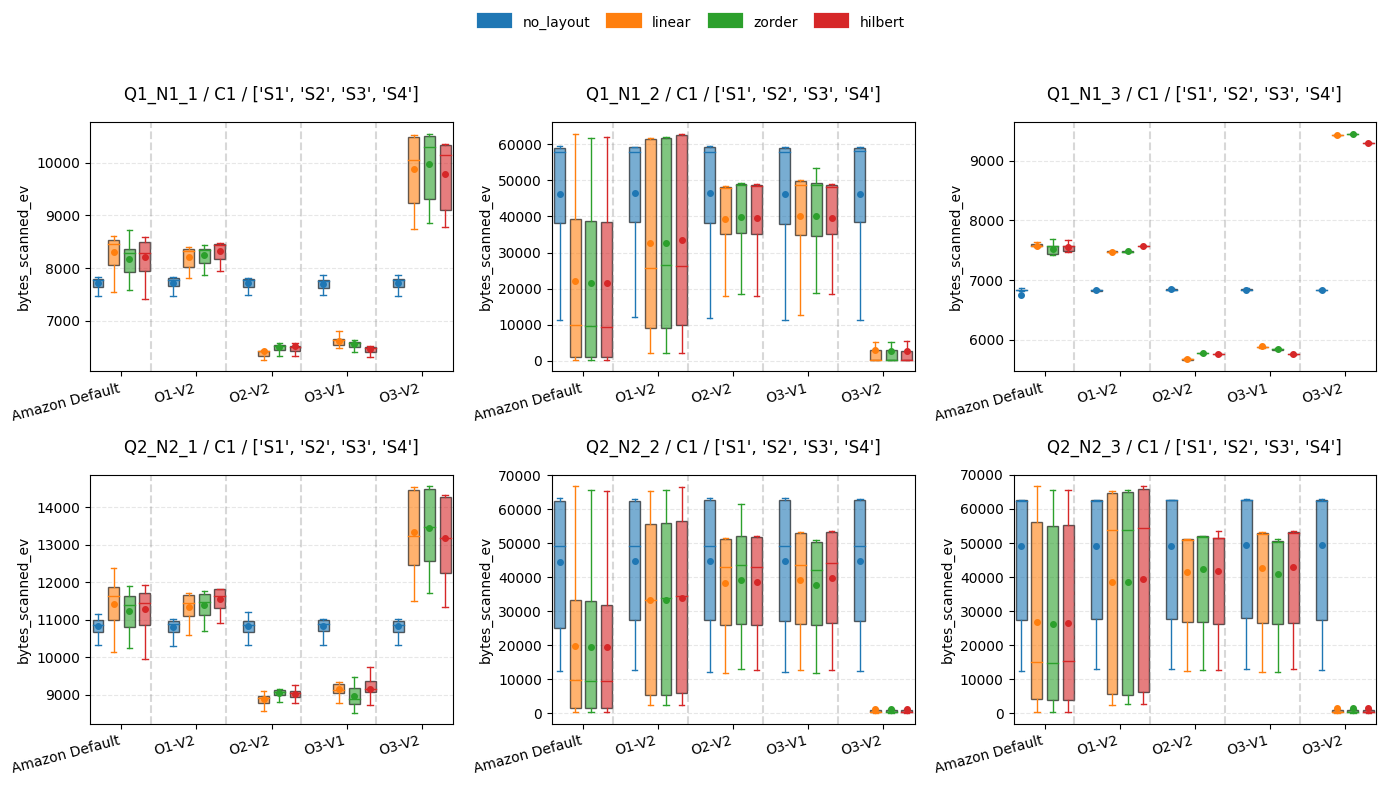

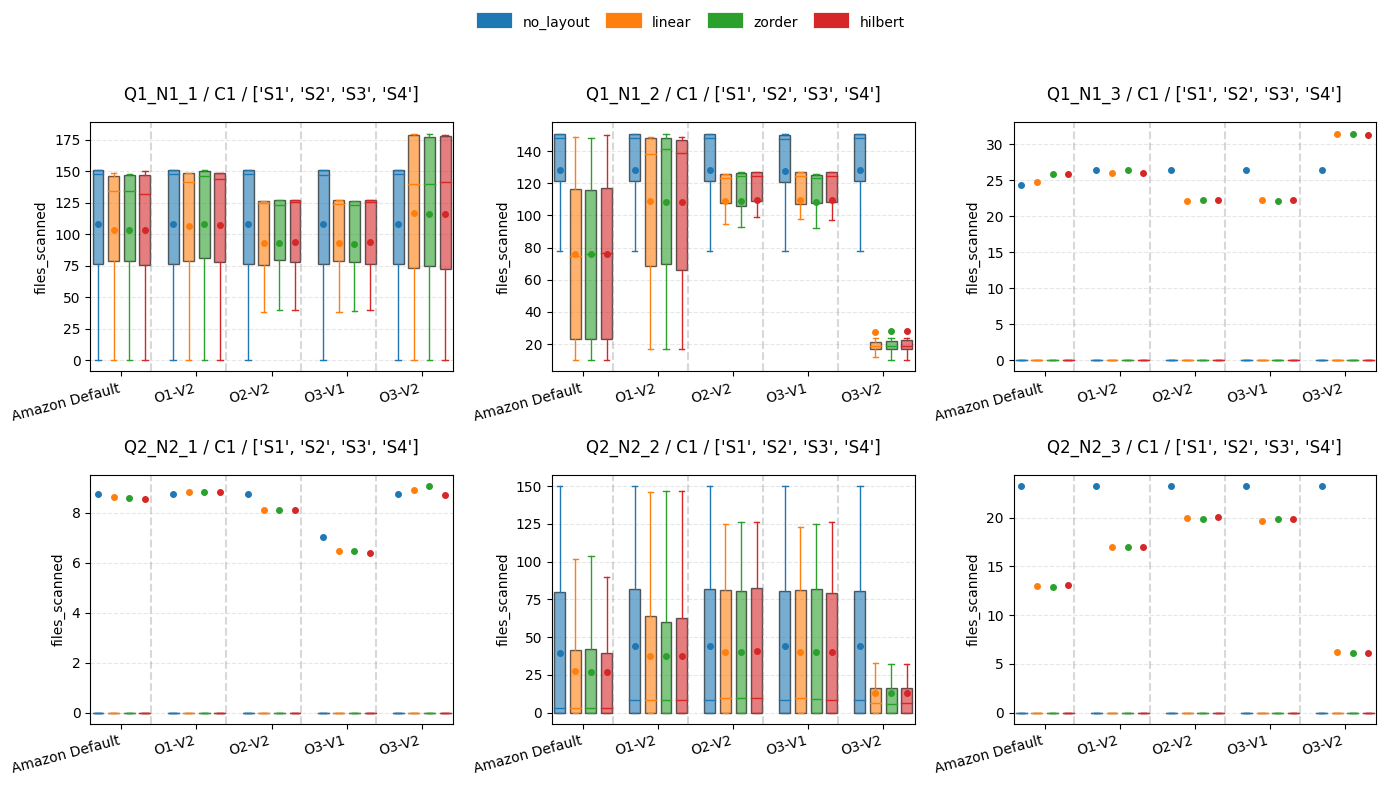

In [24]:
fig, _ = plot_rq1_amazon_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3",
    "Q2_N2_1", "Q2_N2_2", "Q2_N2_3"],
    selectivity_filter=["S1","S2","S3","S4"],
    column_config_limit=1,
    metric="bytes_scanned_ev",
    filename="rq1_amazon_Q1_Q2_S_all_bytes_scanned_ev",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3",
    "Q2_N2_1", "Q2_N2_2", "Q2_N2_3"],
    selectivity_filter=["S1","S2","S3","S4"],
    column_config_limit=1,
    metric="files_scanned",
    filename="rq1_amazon_Q1_Q2_S_all_files_scanned",
)



/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_bytes_scanned.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_files_scanned.pdf


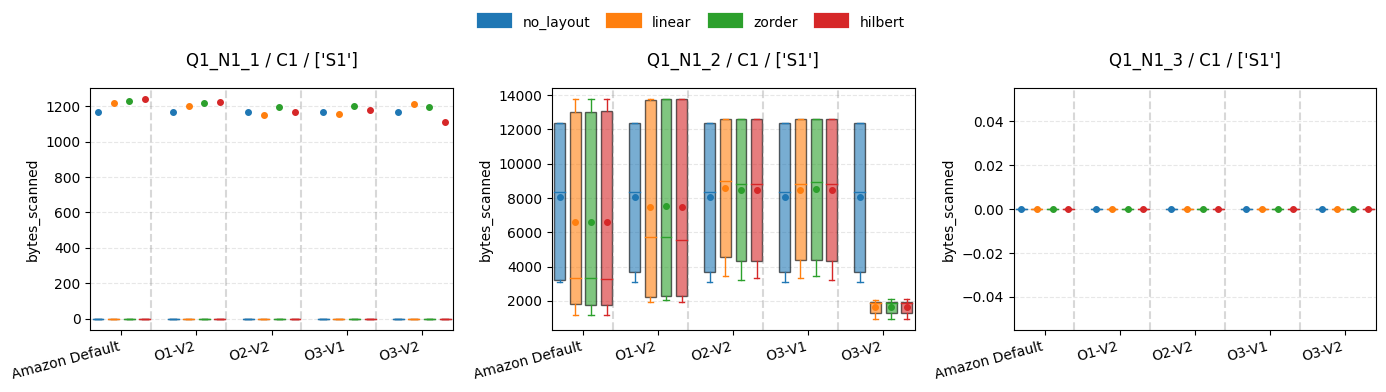

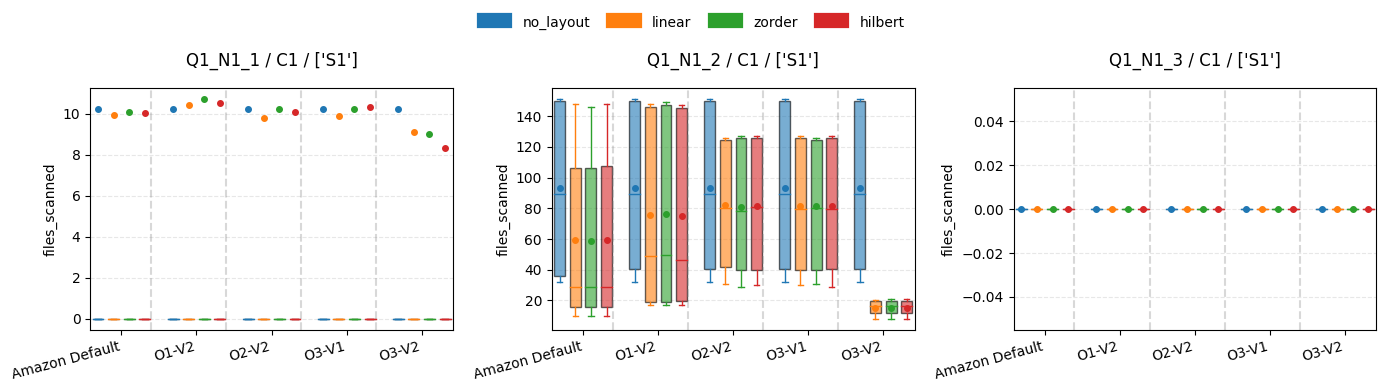

In [5]:
fig, _ = plot_rq1_amazon_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3"],
    selectivity_filter=["S1"],
    column_config_limit=1,
    metric="bytes_scanned",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3"],
    selectivity_filter=["S1"],
    column_config_limit=1,
    metric="files_scanned",
)

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_bytes_scanned.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_files_scanned.pdf


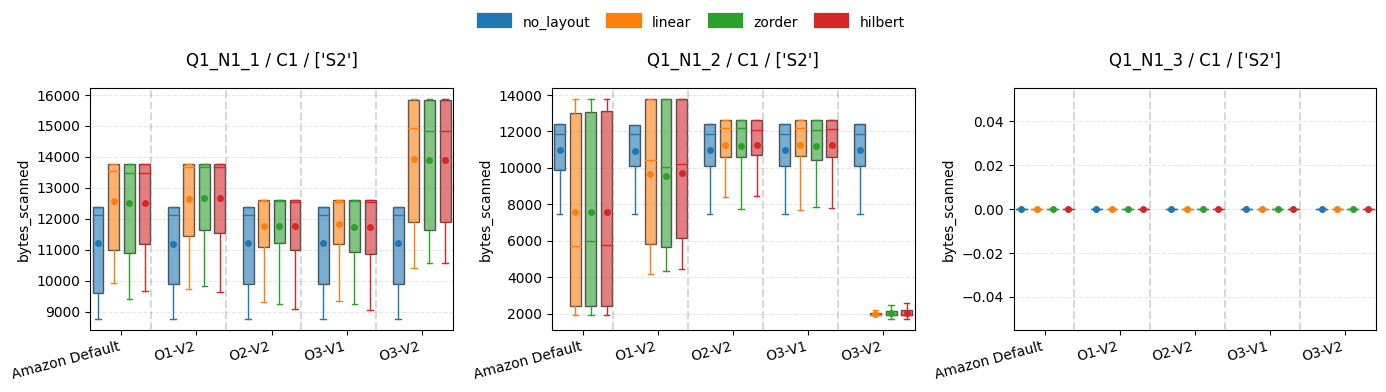

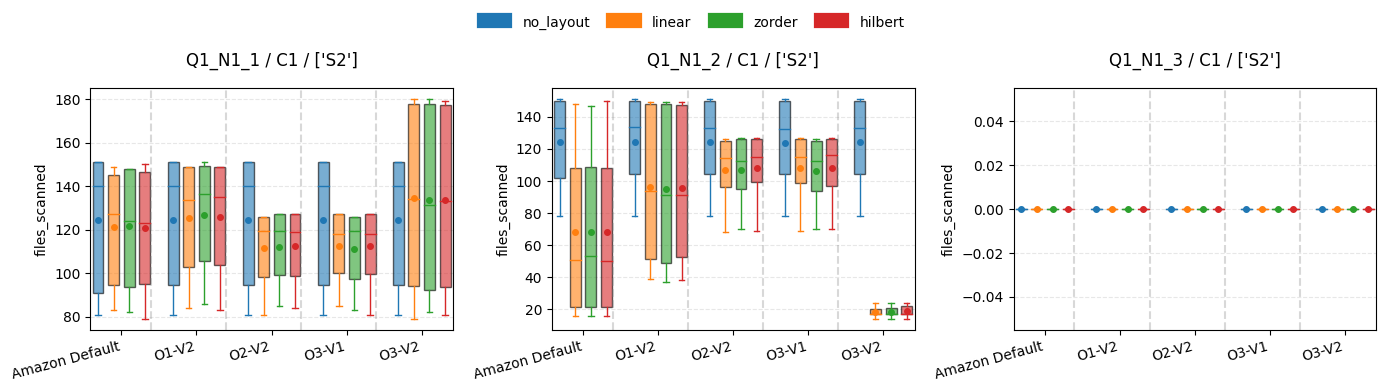

In [6]:
fig, _ = plot_rq1_amazon_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3"],
    selectivity_filter=["S2"],
    column_config_limit=1,
    metric="bytes_scanned",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3"],
    selectivity_filter=["S2"],
    column_config_limit=1,
    metric="files_scanned",
)

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_bytes_scanned.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_files_scanned.pdf


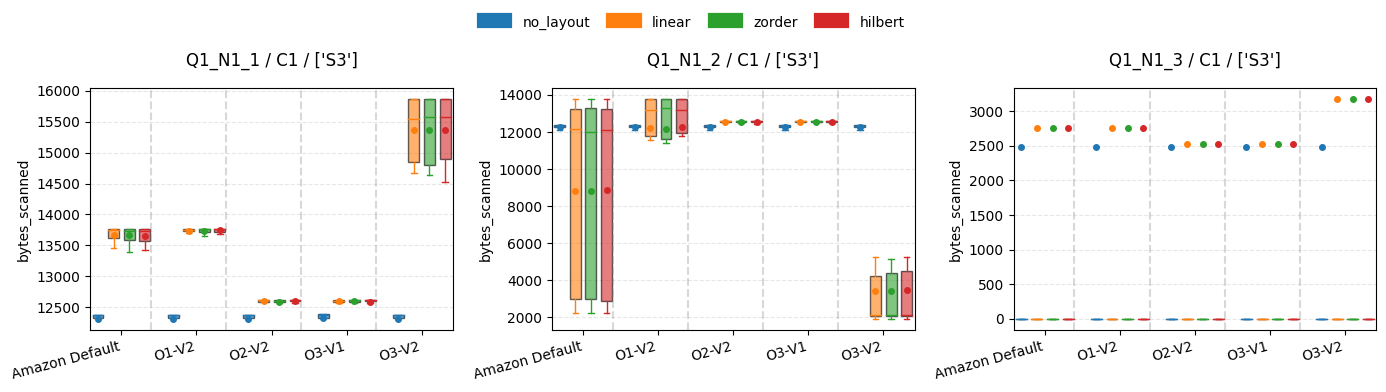

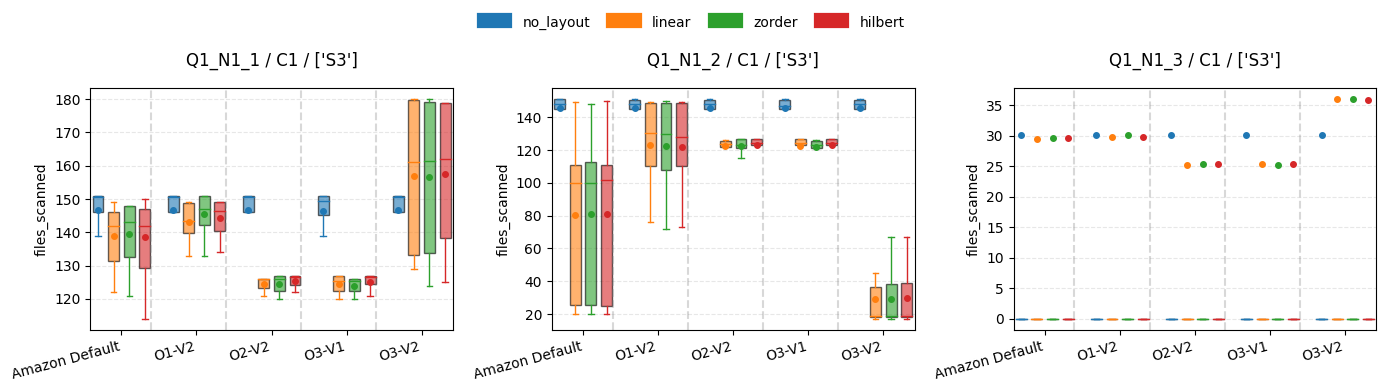

In [8]:
fig, _ = plot_rq1_amazon_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3"],
    selectivity_filter=["S3"],
    column_config_limit=1,
    metric="bytes_scanned",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3"],
    selectivity_filter=["S3"],
    column_config_limit=1,
    metric="files_scanned",
)

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_bytes_scanned.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q1_N1_1_Q1_N1_2_Q1_N1_3_files_scanned.pdf


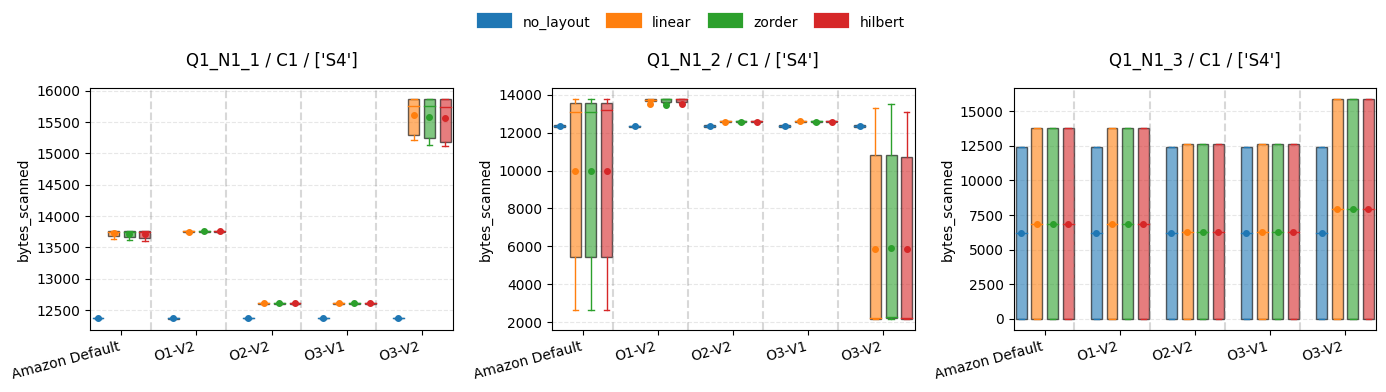

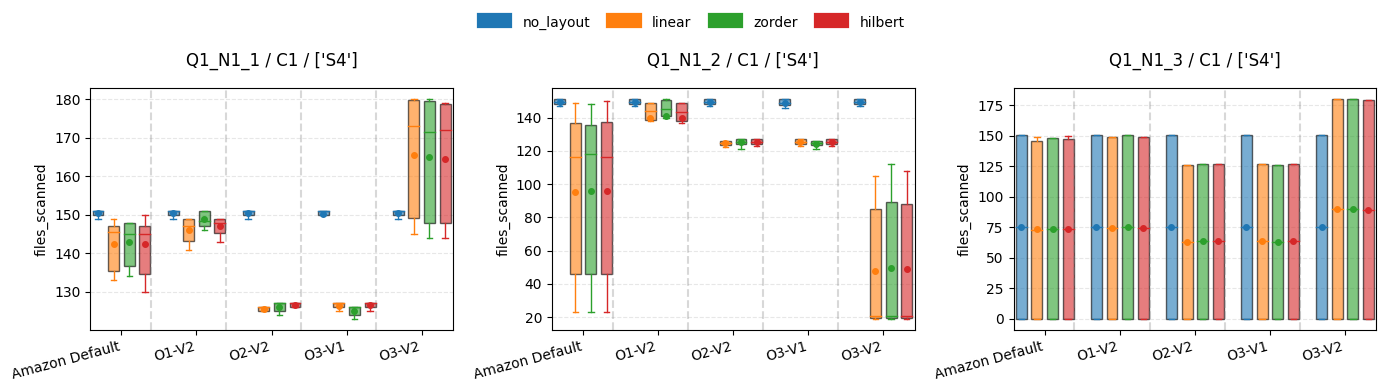

In [9]:
fig, _ = plot_rq1_amazon_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3"],
    selectivity_filter=["S4"],
    column_config_limit=1,
    metric="bytes_scanned",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q1_N1_1", "Q1_N1_2", "Q1_N1_3"],
    selectivity_filter=["S4"],
    column_config_limit=1,
    metric="files_scanned",
)

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_bytes_scanned.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_files_scanned.pdf


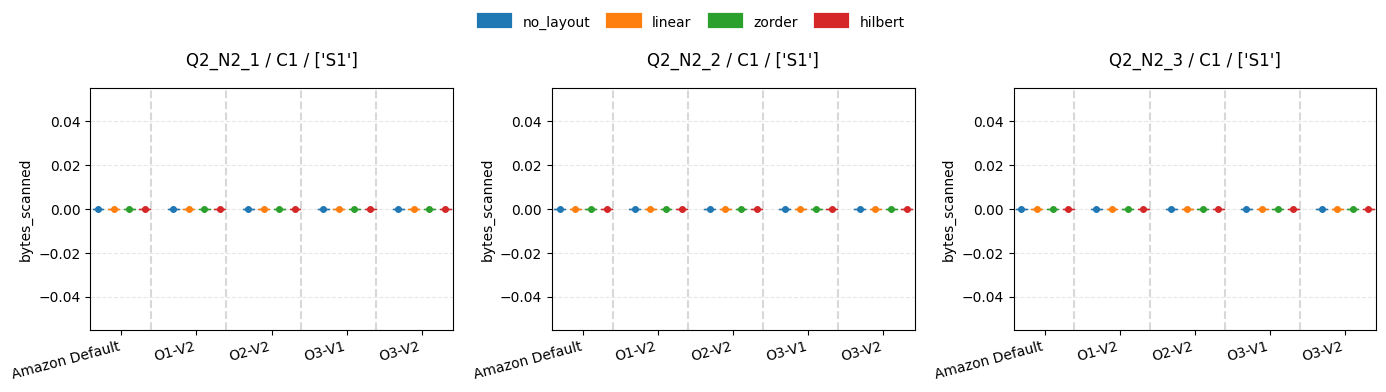

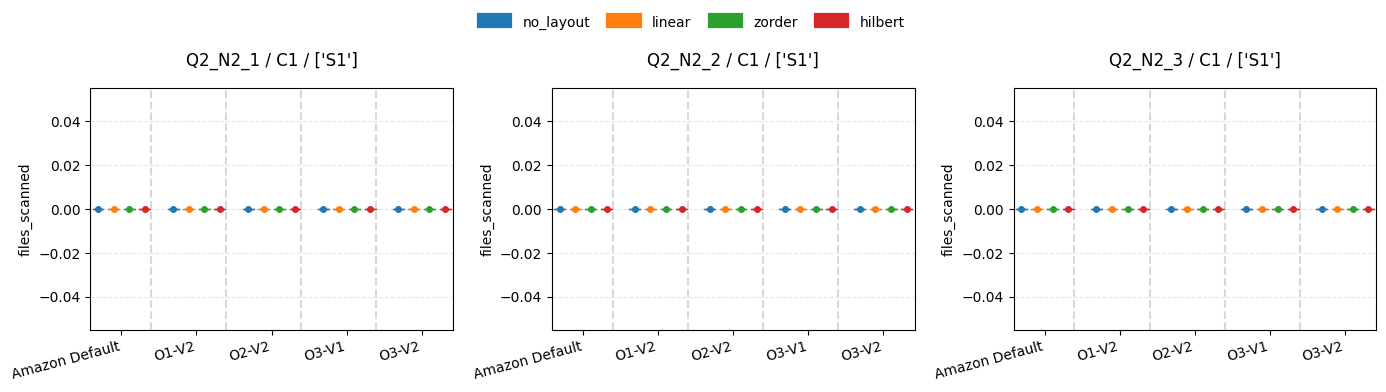

In [10]:
fig, _ = plot_rq1_amazon_queries(
    ["Q2_N2_1", "Q2_N2_2", "Q2_N2_3"],
    selectivity_filter=["S1"],
    column_config_limit=1,
    metric="bytes_scanned",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q2_N2_1", "Q2_N2_2", "Q2_N2_3"],
    selectivity_filter=["S1"],
    column_config_limit=1,
    metric="files_scanned",
)

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_bytes_scanned.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_files_scanned.pdf


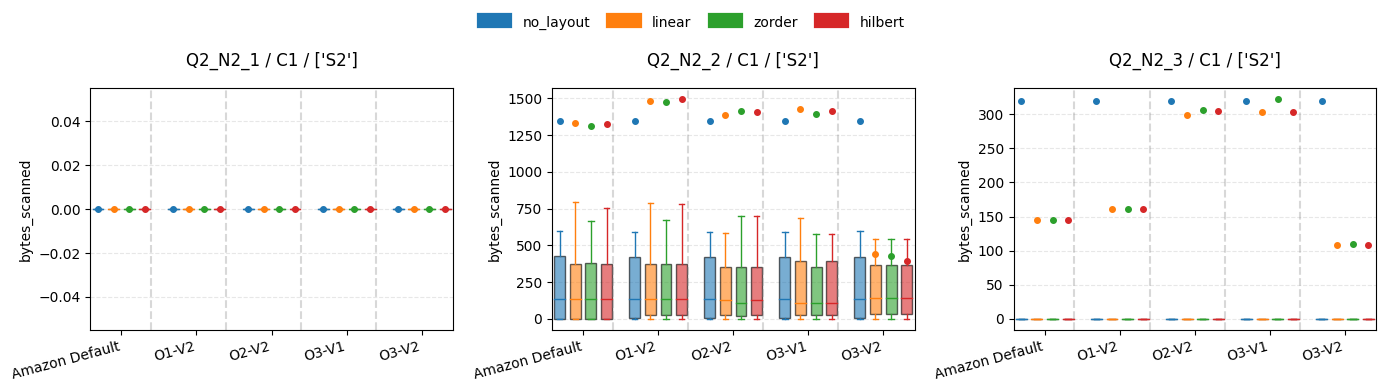

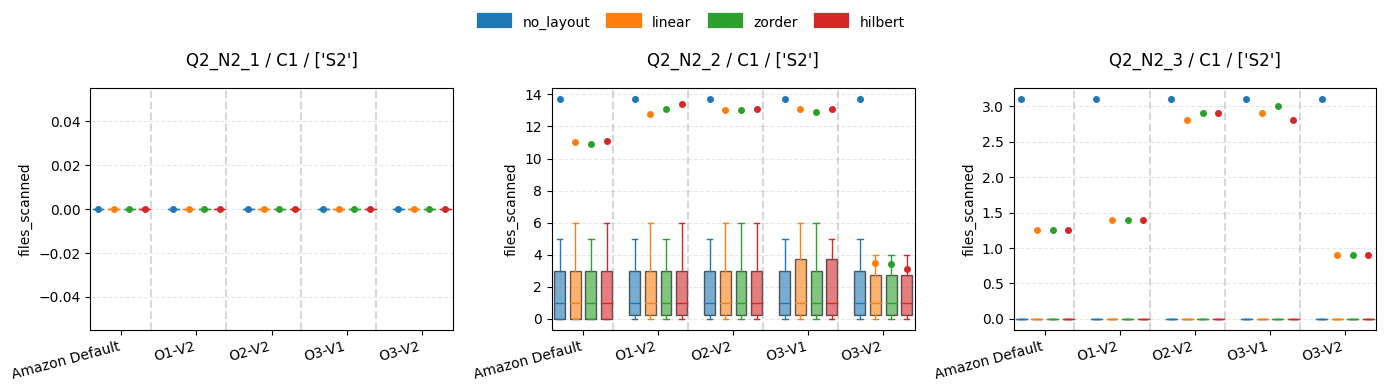

In [11]:
fig, _ = plot_rq1_amazon_queries(
    ["Q2_N2_1", "Q2_N2_2", "Q2_N2_3"],
    selectivity_filter=["S2"],
    column_config_limit=1,
    metric="bytes_scanned",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q2_N2_1", "Q2_N2_2", "Q2_N2_3"],
    selectivity_filter=["S2"],
    column_config_limit=1,
    metric="files_scanned",
)

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_bytes_scanned.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_files_scanned.pdf


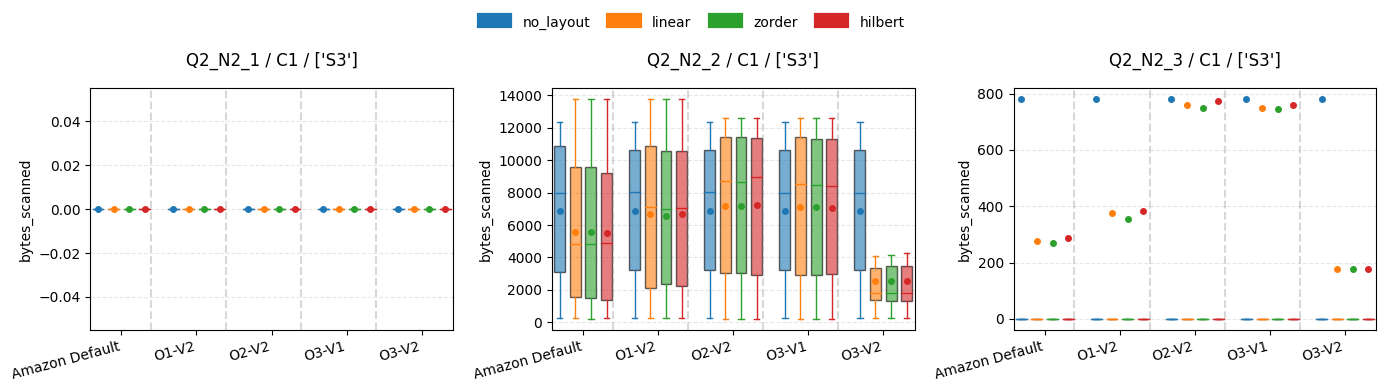

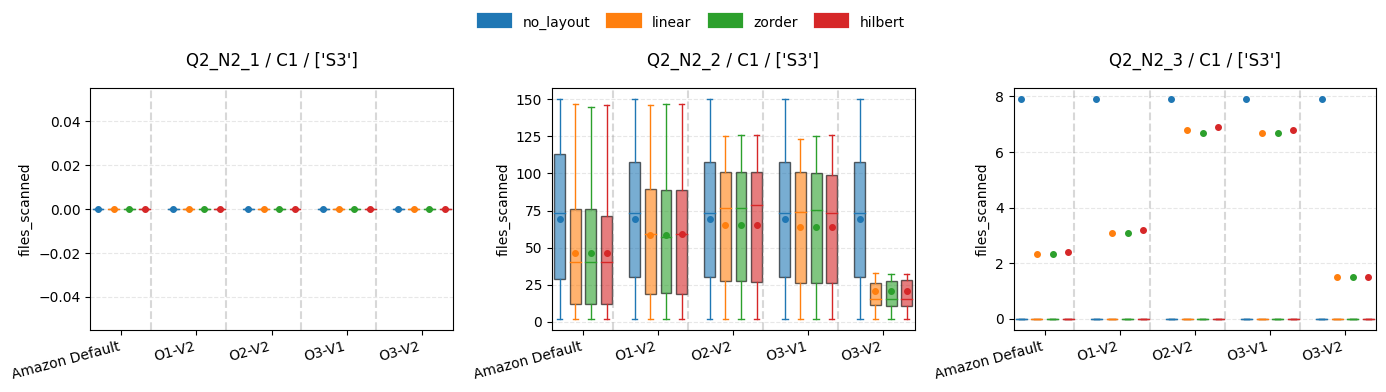

In [12]:
fig, _ = plot_rq1_amazon_queries(
    ["Q2_N2_1", "Q2_N2_2", "Q2_N2_3"],
    selectivity_filter=["S3"],
    column_config_limit=1,
    metric="bytes_scanned",
)

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_bytes_scanned.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q2_N2_1_Q2_N2_2_Q2_N2_3_files_scanned.pdf


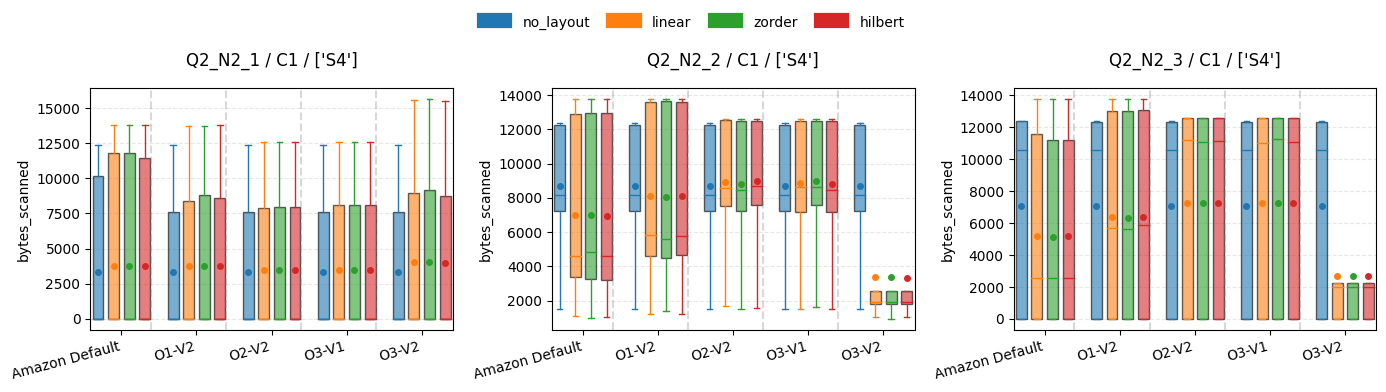

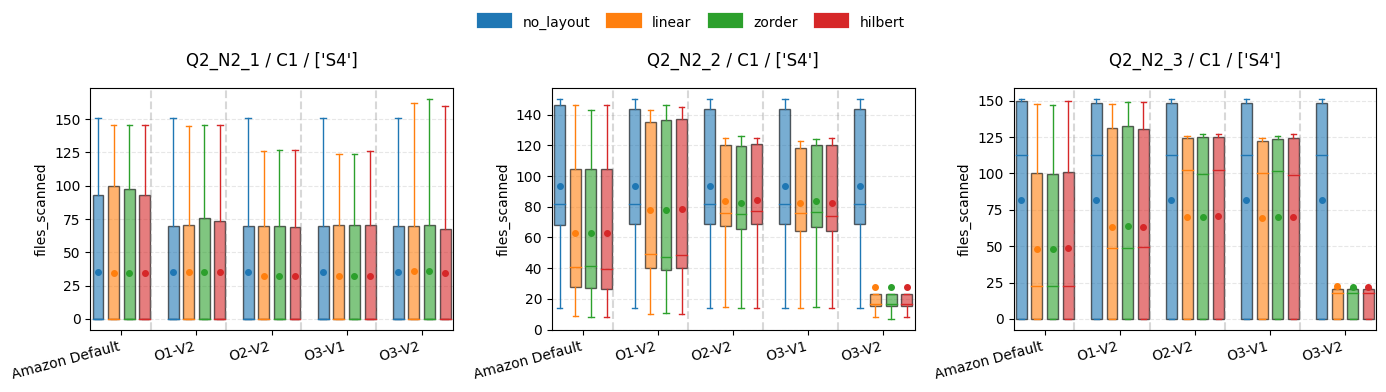

In [13]:
fig, _ = plot_rq1_amazon_queries(
    ["Q2_N2_1", "Q2_N2_2", "Q2_N2_3"],
    selectivity_filter=["S4"],
    column_config_limit=1,
    metric="bytes_scanned",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q2_N2_1", "Q2_N2_2", "Q2_N2_3"],
    selectivity_filter=["S4"],
    column_config_limit=1,
    metric="files_scanned",
)

/Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/scripts/parse_tpch_results.py:587: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(frames, ignore_index=True)
/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K1_1_Q3_K1_2_Q3_K1_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K1_1_Q3_K1_2_Q3_K1_3_bytes_scanned.pdf


/Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/scripts/parse_tpch_results.py:587: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(frames, ignore_index=True)
/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K1_1_Q3_K1_2_Q3_K1_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K1_1_Q3_K1_2_Q3_K1_3_files_scanned.pdf


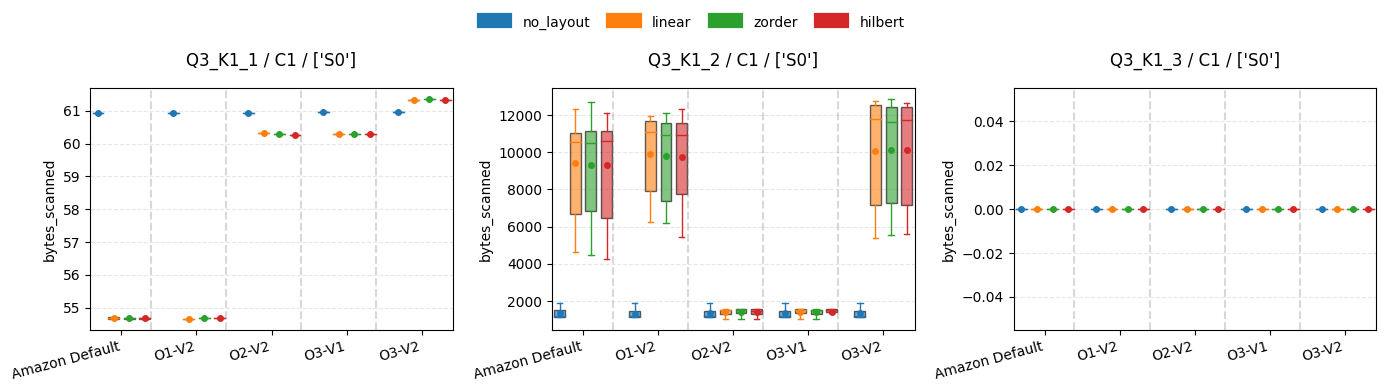

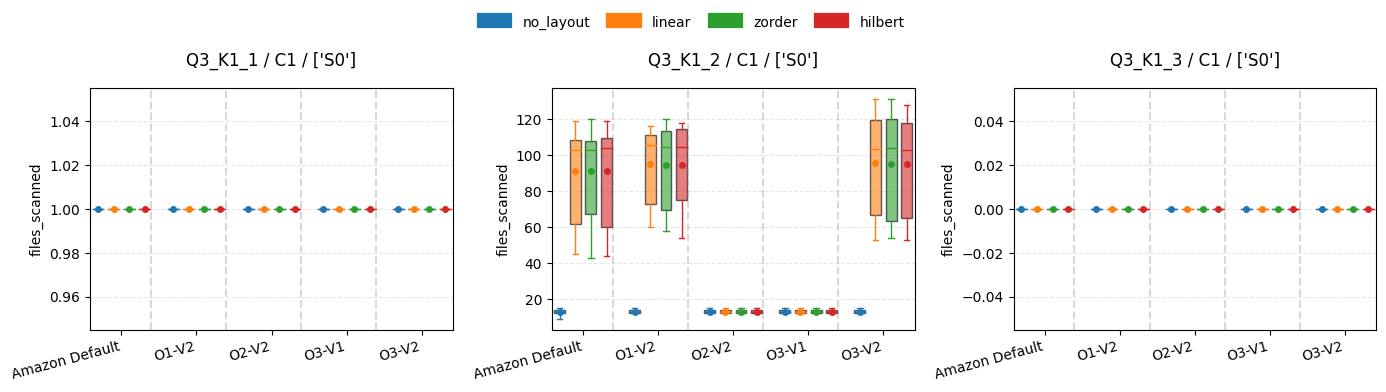

In [14]:
fig, _ = plot_rq1_amazon_queries(
    ["Q3_K1_1", "Q3_K1_2", "Q3_K1_3"],
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="bytes_scanned",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q3_K1_1", "Q3_K1_2", "Q3_K1_3"],
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="files_scanned",
)

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K2_1_Q3_K2_2_Q3_K2_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K2_1_Q3_K2_2_Q3_K2_3_bytes_scanned.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K2_1_Q3_K2_2_Q3_K2_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K2_1_Q3_K2_2_Q3_K2_3_files_scanned.pdf


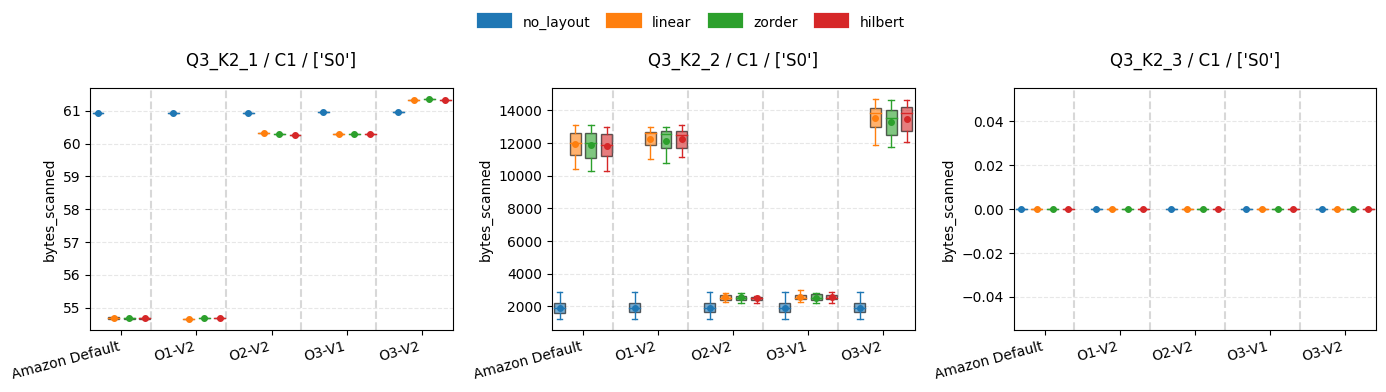

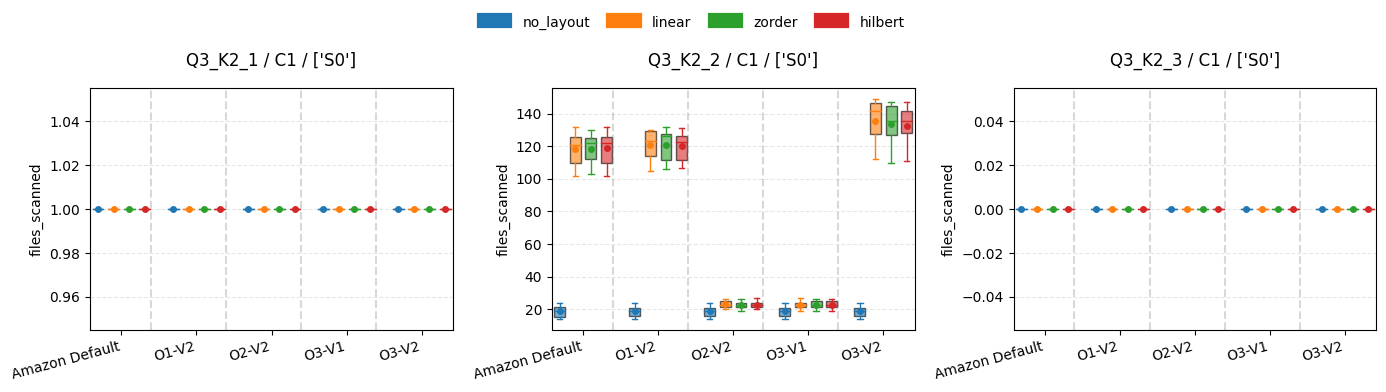

In [15]:
fig, _ = plot_rq1_amazon_queries(
    ["Q3_K2_1", "Q3_K2_2", "Q3_K2_3"],
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="bytes_scanned",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q3_K2_1", "Q3_K2_2", "Q3_K2_3"],
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="files_scanned",
)

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K4_1_Q3_K4_2_Q3_K4_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K4_1_Q3_K4_2_Q3_K4_3_bytes_scanned.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K4_1_Q3_K4_2_Q3_K4_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K4_1_Q3_K4_2_Q3_K4_3_files_scanned.pdf


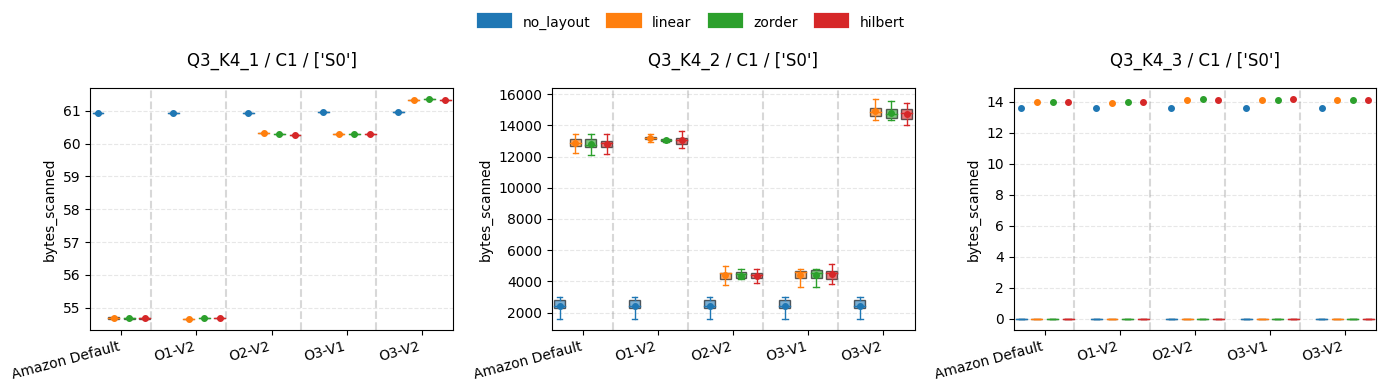

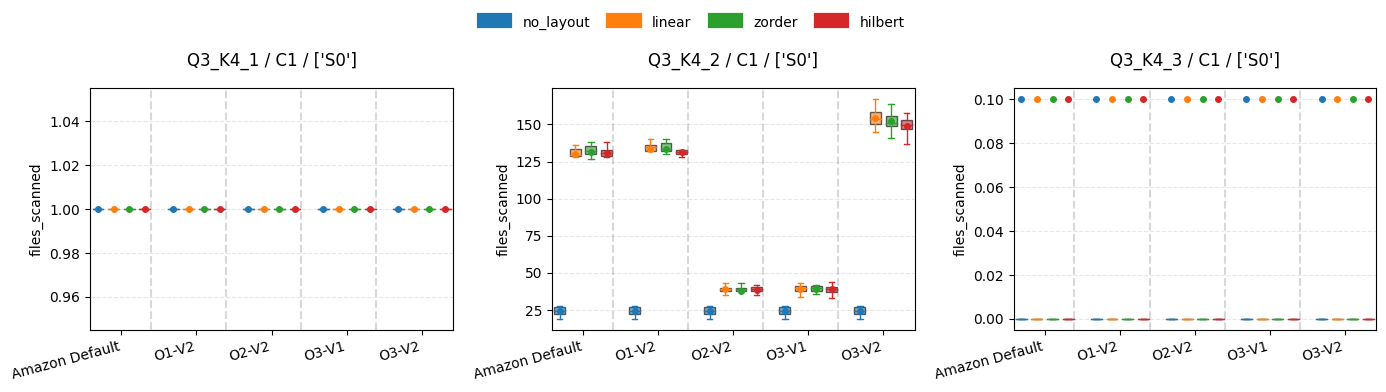

In [16]:
fig, _ = plot_rq1_amazon_queries(
    ["Q3_K4_1", "Q3_K4_2", "Q3_K4_3"],
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="bytes_scanned",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q3_K4_1", "Q3_K4_2", "Q3_K4_3"],
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="files_scanned",
)

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K8_1_Q3_K8_2_Q3_K8_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K8_1_Q3_K8_2_Q3_K8_3_bytes_scanned.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K8_1_Q3_K8_2_Q3_K8_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K8_1_Q3_K8_2_Q3_K8_3_files_scanned.pdf


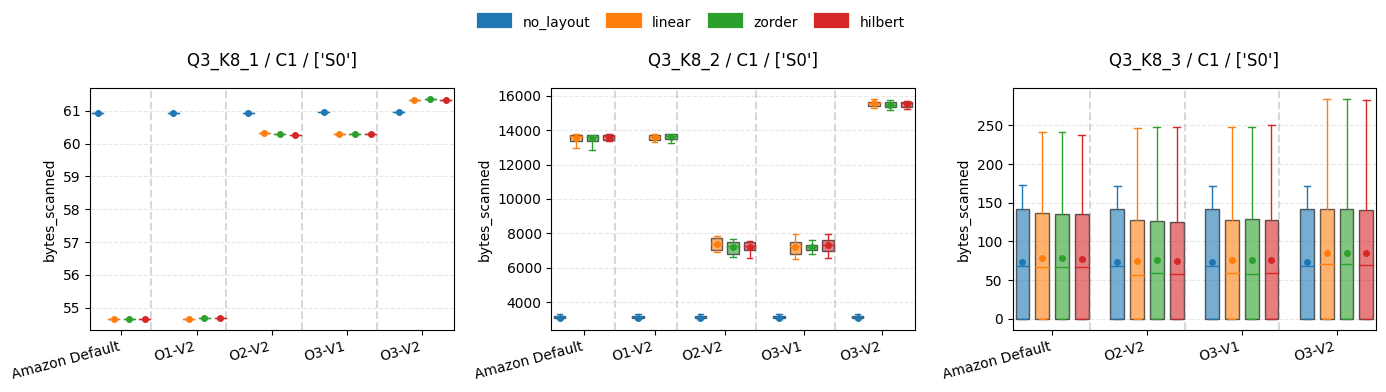

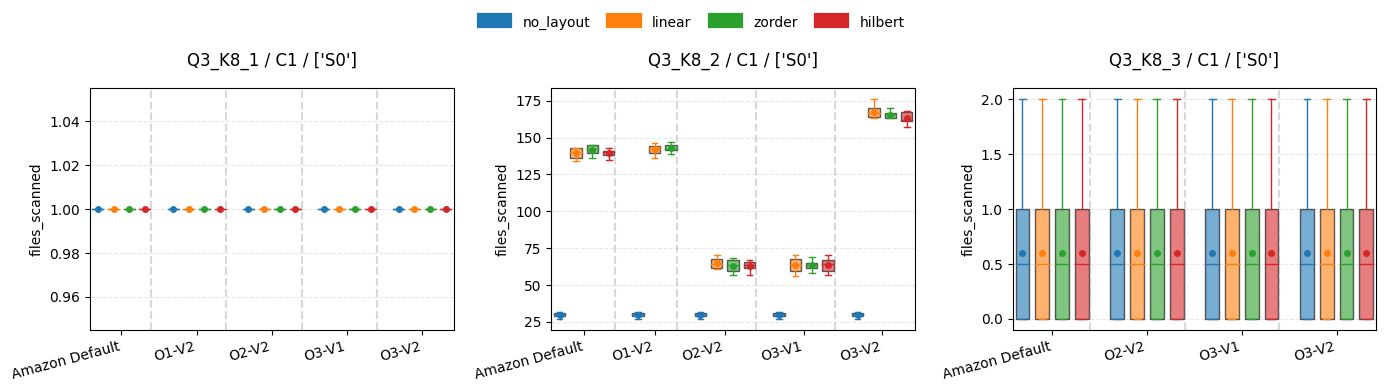

In [17]:
fig, _ = plot_rq1_amazon_queries(
    ["Q3_K8_1", "Q3_K8_2", "Q3_K8_3"],
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="bytes_scanned",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q3_K8_1", "Q3_K8_2", "Q3_K8_3"],
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="files_scanned",
)

/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K16_1_elapsedTime_s.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K16_1_elapsedTime_s.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K16_1_bytesRead_ev.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K16_1_bytesRead_ev.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K16_1_Q3_K16_2_Q3_K16_3_bytes_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K16_1_Q3_K16_2_Q3_K16_3_bytes_scanned.pdf


/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/3486830382.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K16_1_Q3_K16_2_Q3_K16_3_files_scanned.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_K16_1_Q3_K16_2_Q3_K16_3_files_scanned.pdf


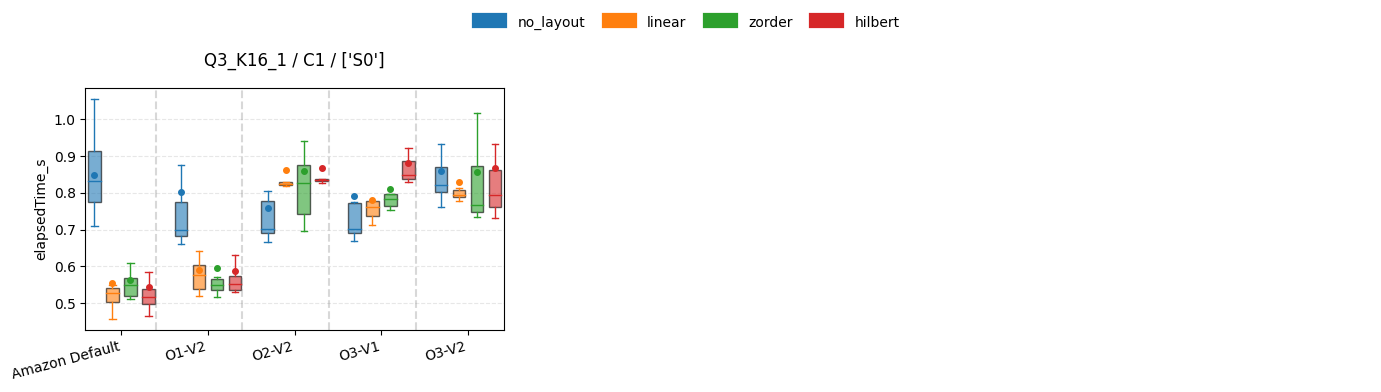

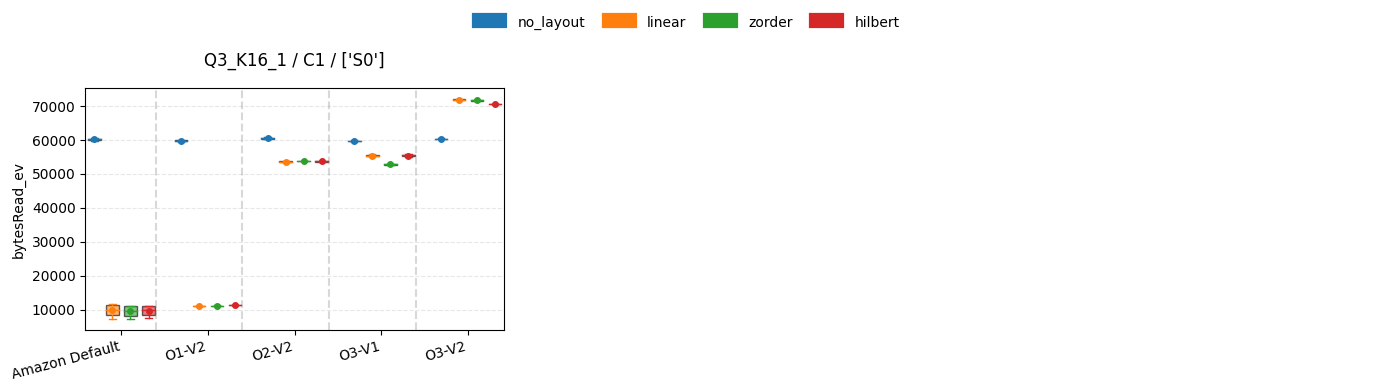

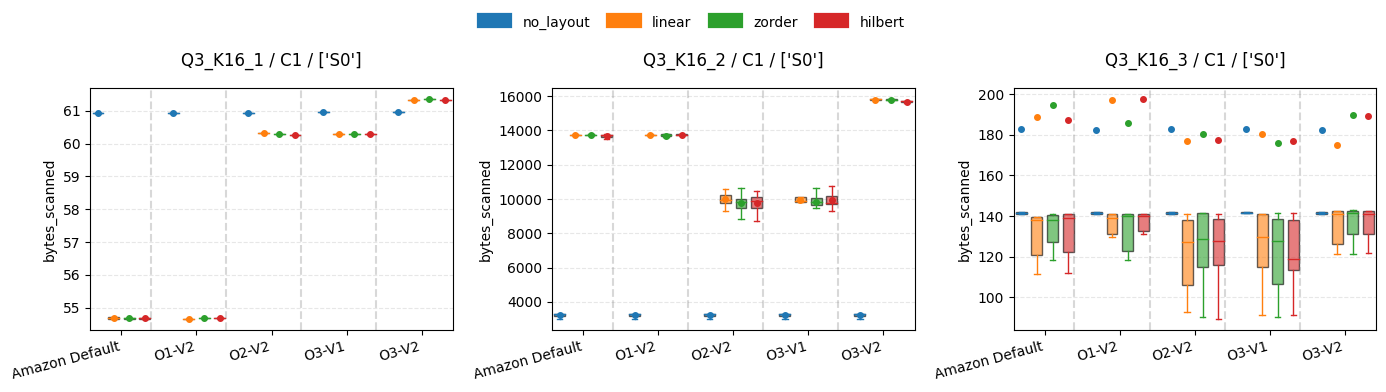

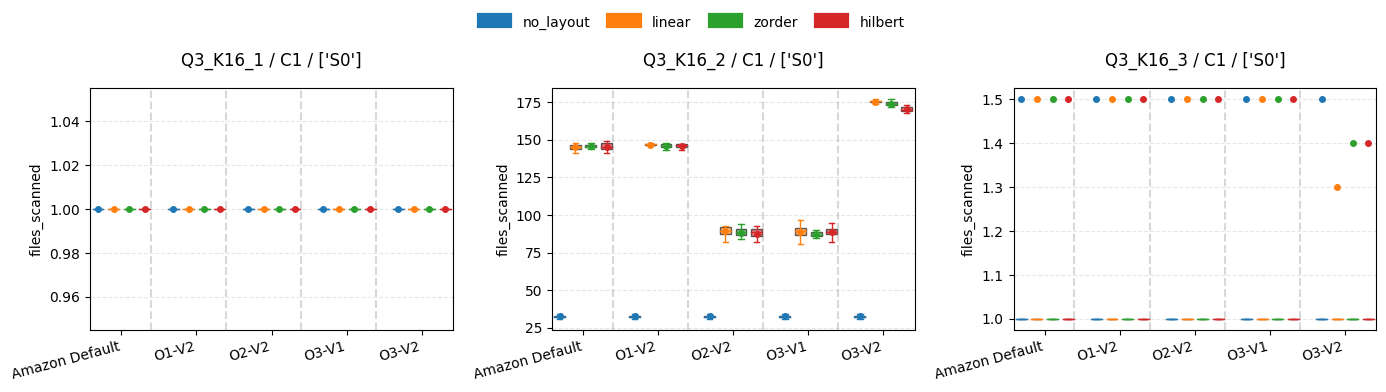

In [18]:
# Example usage: adjust queries/selectivity/metric per cell
fig, _ = plot_rq1_amazon_queries(
    ["Q3_K16_1"],
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="elapsedTime_s",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q3_K16_1"],
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="bytesRead_ev",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q3_K16_1", "Q3_K16_2", "Q3_K16_3"],
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="bytes_scanned",
)

fig, _ = plot_rq1_amazon_queries(
    ["Q3_K16_1", "Q3_K16_2", "Q3_K16_3"],
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="files_scanned",
)




/Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/scripts/parse_tpch_results.py:587: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(frames, ignore_index=True)
/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/2906258016.py:134: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend_obj.legendHandles:


saved: /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_S_all_bytes_scanned_ev.png, /Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/viz_out_results/rq1_amazon_Q3_S_all_bytes_scanned_ev.pdf


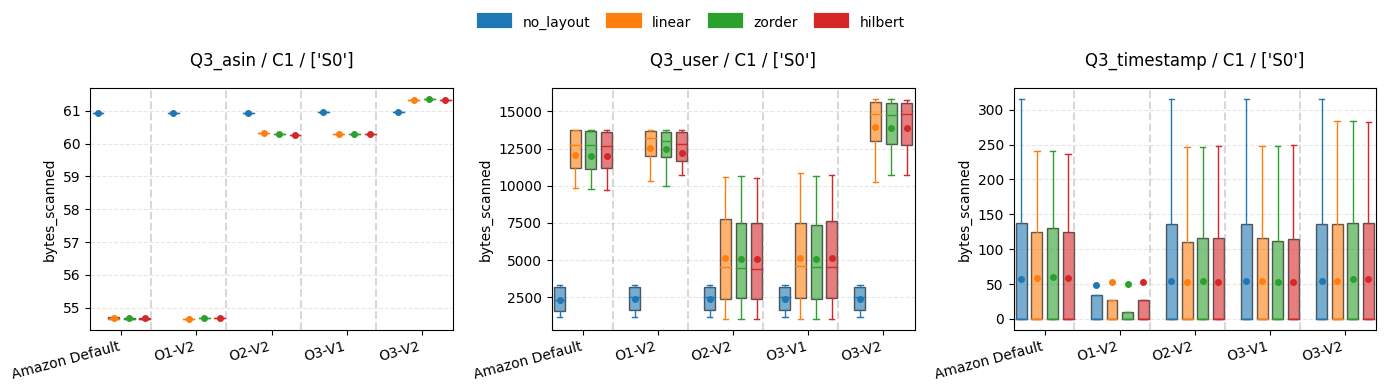

In [25]:

# --- Example: collapse Amazon Q3 fan-outs for multiple predicates ---
AMAZON_Q3_GROUPS = {
    "Q3_asin": [f"Q3_K{k}_1" for k in (1, 2, 4, 8, 16)],
    "Q3_user": [f"Q3_K{k}_2" for k in (1, 2, 4, 8, 16)],
    "Q3_timestamp": [f"Q3_K{k}_3" for k in (1, 2, 4, 8, 16)],
}

fig, _ = plot_rq1_amazon_query_groups(
    AMAZON_Q3_GROUPS,
    selectivity_filter=["S0"],
    column_config_limit=1,
    metric="bytes_scanned",
    legend=True,
    filename="rq1_amazon_Q3_S_all_bytes_scanned_ev",
)


/Users/guanlil1/Dropbox/PostDoc/topics/lakehouse_sfc/scripts/parse_tpch_results.py:587: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(frames, ignore_index=True)
/var/folders/3p/hf0jsts95lxgzw6tlfy59w0w0000gn/T/ipykernel_72210/891491259.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(frames, ignore_index=True)


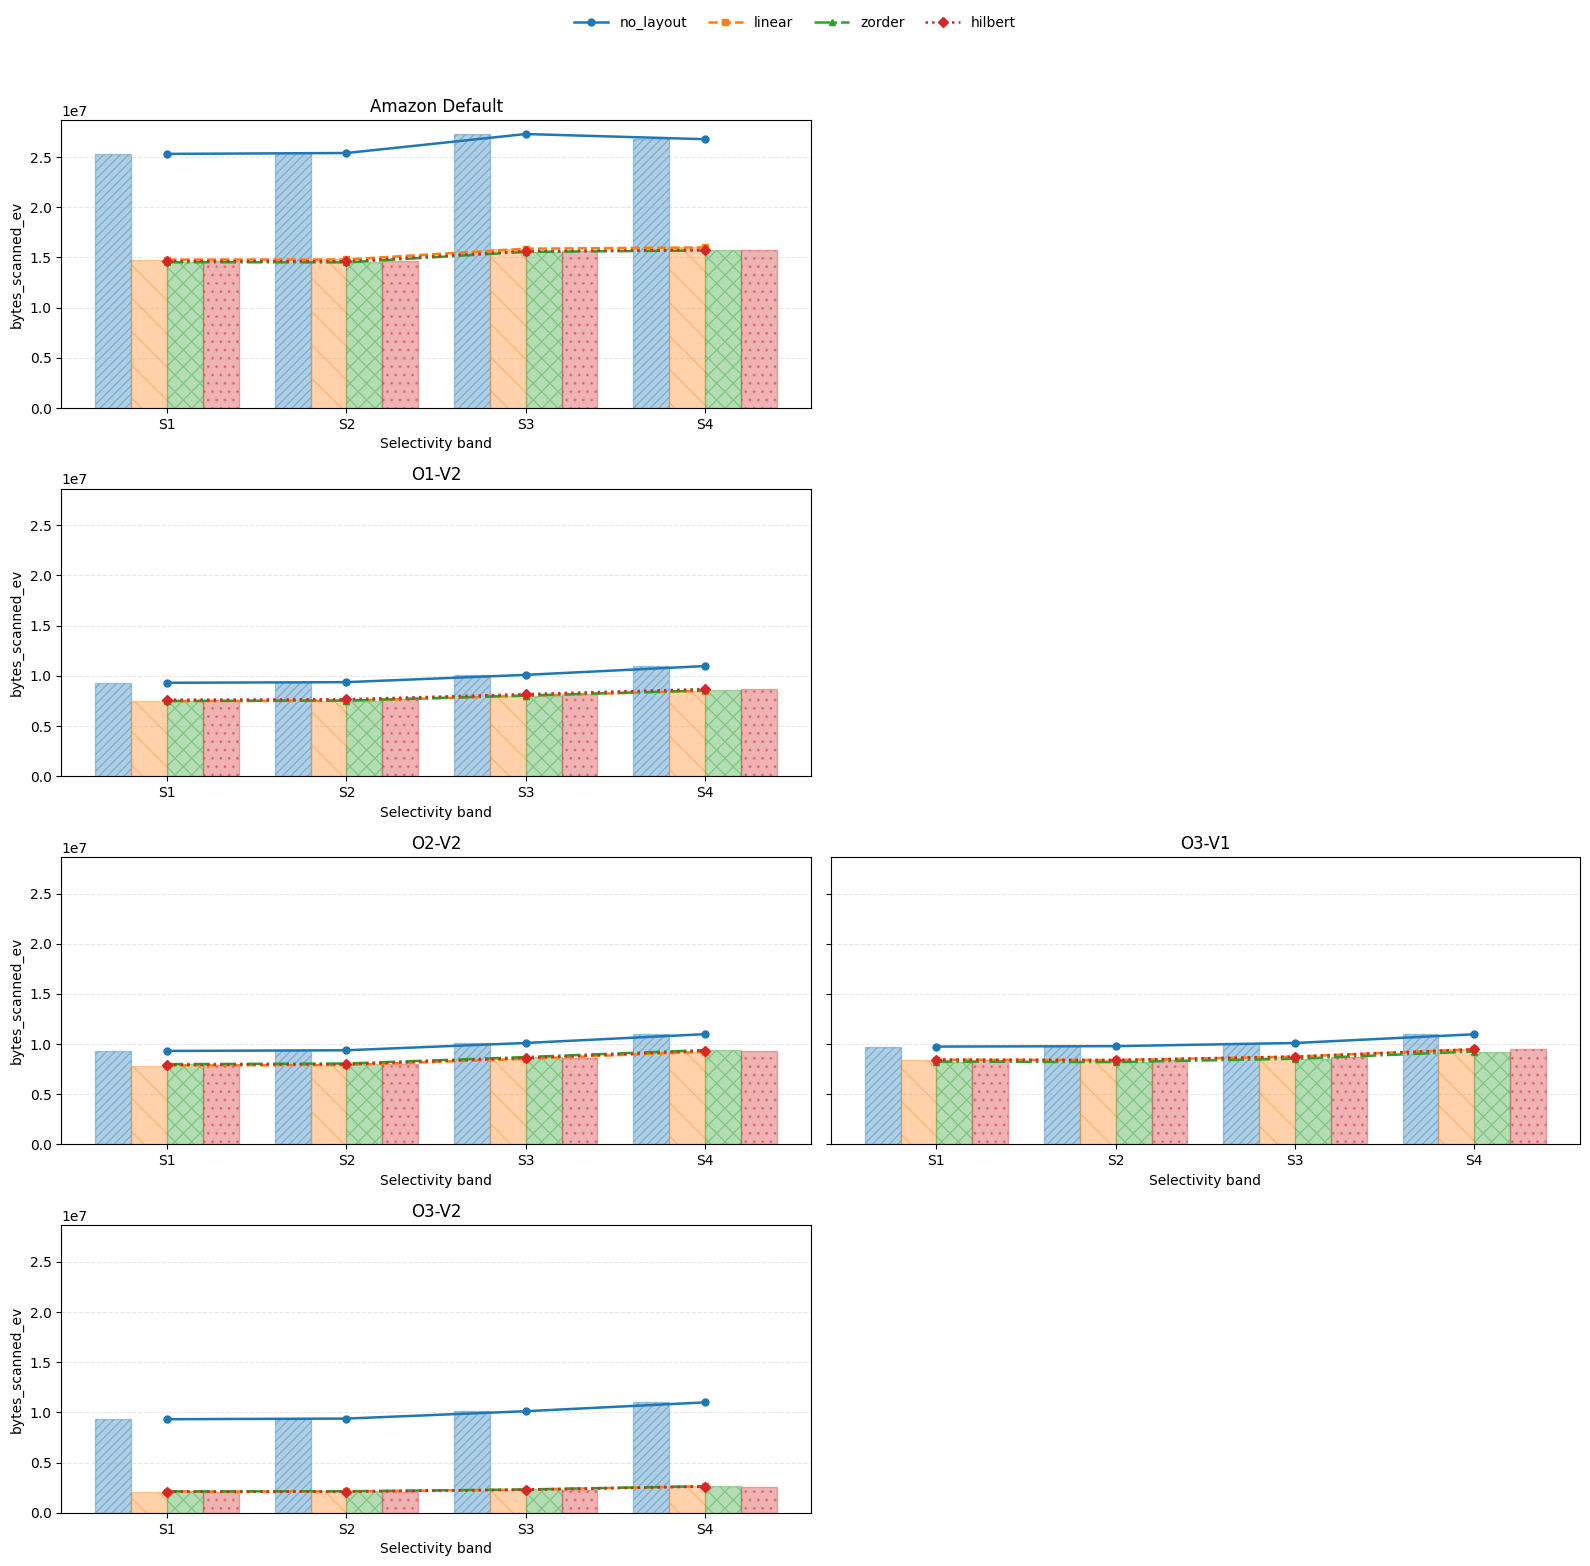

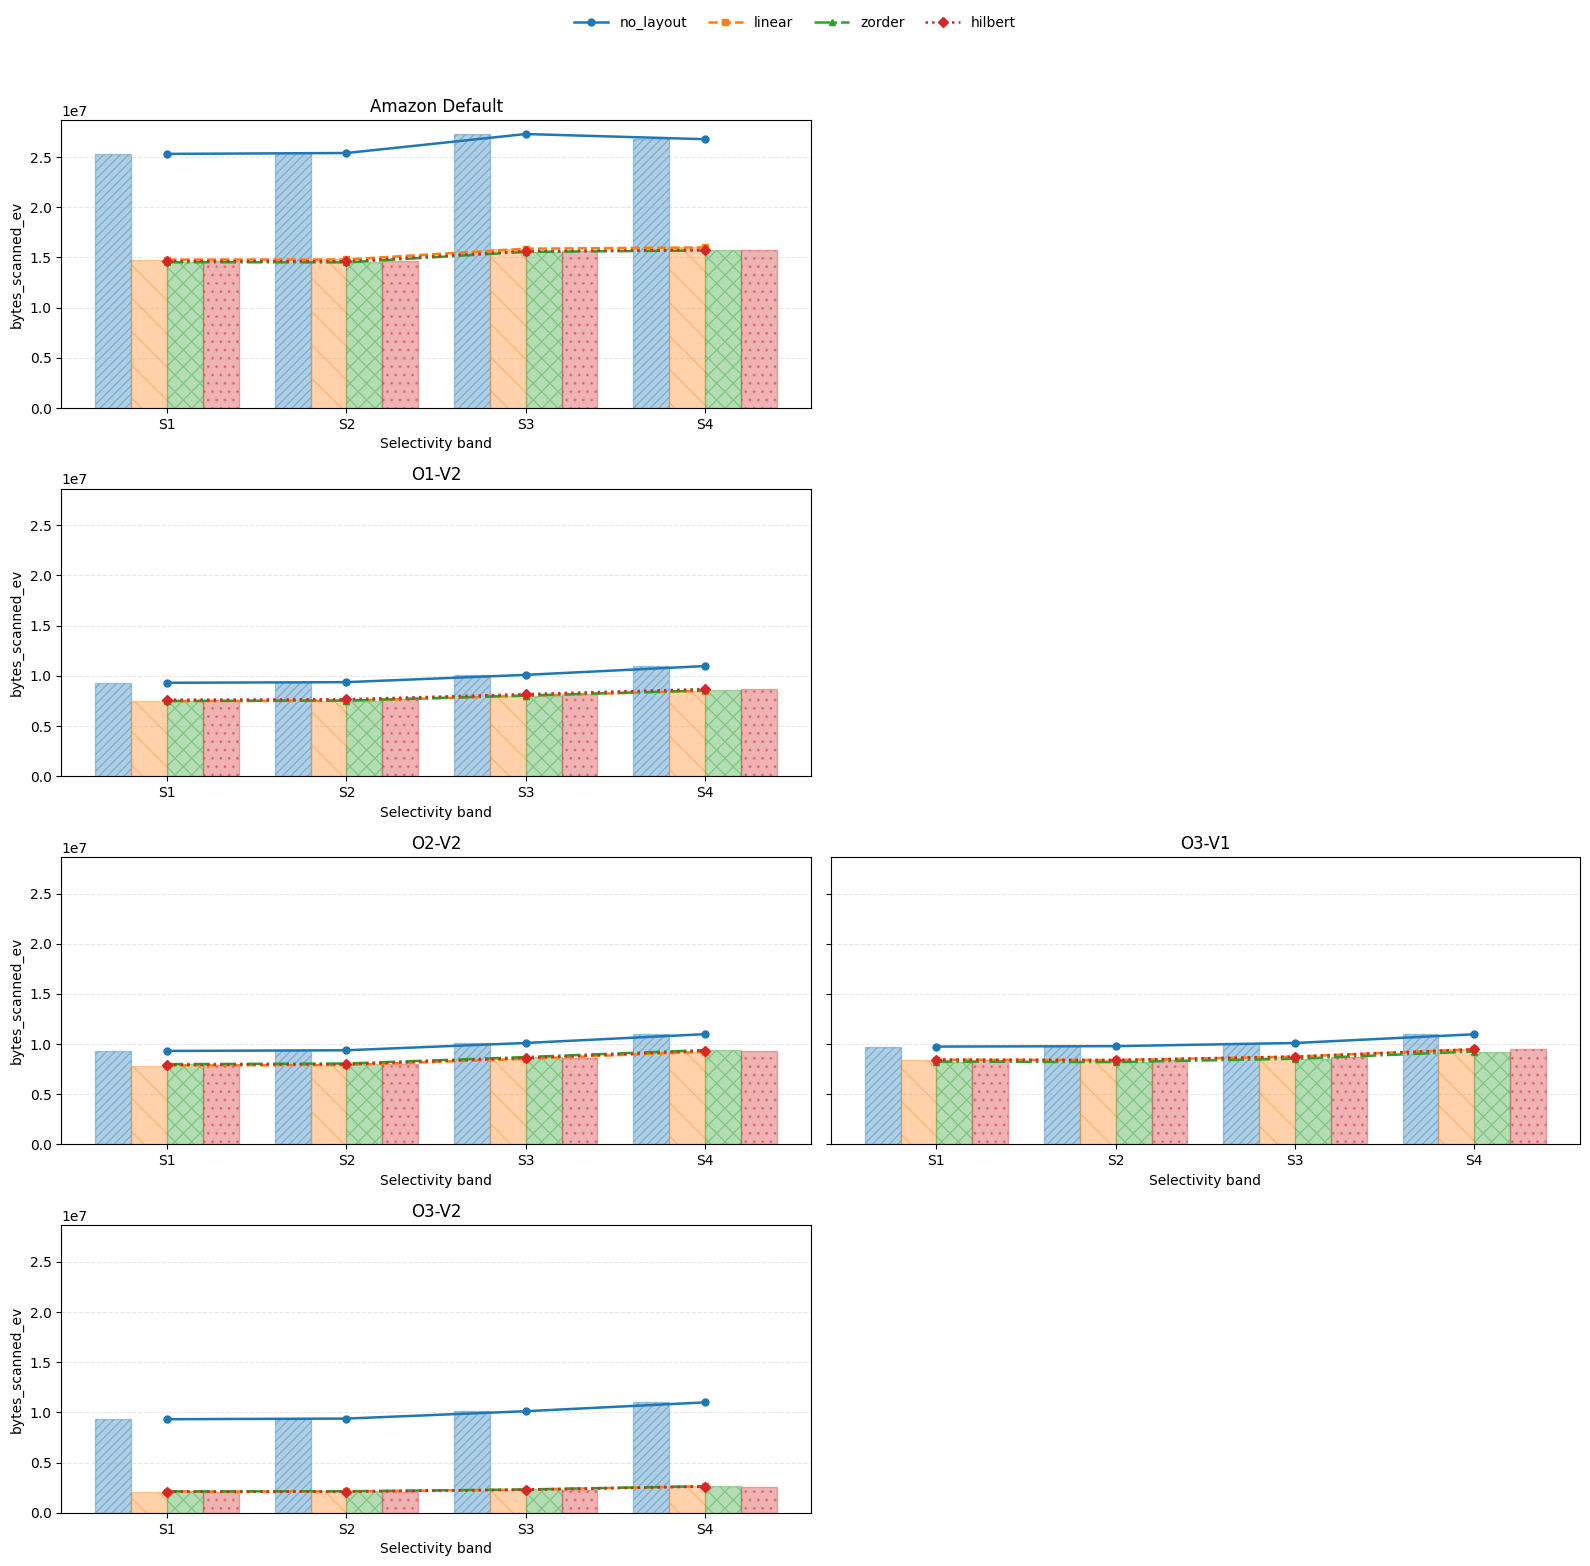

In [29]:

# --- Selectivity sweep: Amazon aggregate bytes scanned per layout/scenario ---
AMAZON_SELECTIVITY_SEQUENCE = ["S1", "S2", "S3", "S4"]

def plot_amazon_selectivity_bytes_trend(
    queries=None,
    *,
    metric="bytes_scanned_ev",
    selectivities=None,
    layout_order=None,
    scenario_order=None,
    legend=True,
    log_scale=False,
):
    collection = collect_amazon_rq1_results()
    scenario_order = scenario_order or list(SCENARIO_DISPLAY.keys())
    layout_order = layout_order or LAYOUT_ORDER
    selectivities = selectivities or AMAZON_SELECTIVITY_SEQUENCE
    if not selectivities:
        raise ValueError("Provide at least one selectivity label")
    query_ids = list(queries) if queries else sorted(collection.by_query().keys())
    frames = []
    for query_id in query_ids:
        try:
            df_query = query_results_dataframe(collection, query_id)
        except ValueError as exc:
            print(exc)
            continue
        frames.append(df_query)
    if not frames:
        raise ValueError("No query data loaded; check query ids")
    df = pd.concat(frames, ignore_index=True)
    df = df[df["selectivity_label"].isin(selectivities)].copy()
    if df.empty:
        raise ValueError("No rows matched the selected selectivity labels")
    df = df[df["layout"].isin(layout_order) & df["scenario_name"].isin(scenario_order)]
    agg = (
        df.groupby(["scenario_name", "layout", "selectivity_label"], as_index=False)[metric]
        .sum()
    )

    ncols = 2
    nrows = math.ceil(len(scenario_order) / ncols) or 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows), sharey=True, squeeze=False)
    legend_handles = {}
    positions = list(range(len(selectivities)))

    for idx, scenario in enumerate(scenario_order):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        subset = agg[agg["scenario_name"] == scenario]
        if subset.empty:
            ax.set_visible(False)
            continue
        layouts_present = [lay for lay in layout_order if lay in subset["layout"].unique()]
        if not layouts_present:
            ax.set_visible(False)
            continue
        bar_width = min(0.8 / max(1, len(layouts_present)), 0.25)
        offsets = [
            (i - (len(layouts_present) - 1) / 2) * bar_width
            for i in range(len(layouts_present))
        ]
        for offset, layout in zip(offsets, layouts_present):
            layout_data = subset[subset["layout"] == layout]
            values = []
            for sel in selectivities:
                match = layout_data[layout_data["selectivity_label"] == sel]
                values.append(match[metric].sum() if not match.empty else 0.0)
            color = LAYOUT_COLORS.get(layout, "#666666")
            hatch = LAYOUT_HATCHES.get(layout)
            marker = LAYOUT_MARKERS.get(layout, "o")
            linestyle = LAYOUT_LINESTYLES.get(layout, "-")
            x_positions = [pos + offset for pos in positions]
            ax.bar(
                x_positions,
                values,
                width=bar_width,
                color=color,
                alpha=0.35,
                edgecolor=color,
                linewidth=1.0,
                hatch=hatch,
            )
            line, = ax.plot(
                positions,
                values,
                color=color,
                marker=marker,
                markersize=5,
                linestyle=linestyle,
                linewidth=1.8,
            )
            legend_handles.setdefault(layout, line)
        ax.set_title(SCENARIO_DISPLAY.get(scenario, scenario))
        ax.set_xticks(positions)
        ax.set_xticklabels(selectivities)
        ax.set_xlabel("Selectivity band")
        if c == 0:
            ax.set_ylabel(metric)
        if log_scale:
            ax.set_yscale('log')
        ax.set_ylim(bottom=0)
        ax.grid(axis='y', linestyle='--', alpha=0.3)

    for idx in range(len(scenario_order), nrows * ncols):
        r, c = divmod(idx, ncols)
        axes[r][c].axis('off')

    if legend and legend_handles:
        fig.legend(
            legend_handles.values(),
            legend_handles.keys(),
            loc='upper center',
            ncol=len(legend_handles),
            frameon=False,
            columnspacing=1.5,
            handlelength=2.5,
            bbox_to_anchor=(0.5, 0.98),
        )
    fig.tight_layout(rect=(0, 0, 1, 0.93))
    return fig, agg

fig_amazon_selectivity, amazon_selectivity_summary = plot_amazon_selectivity_bytes_trend(
    metric="bytes_scanned_ev",
    selectivities=["S1", "S2", "S3", "S4"],
    legend=True,
)
fig_amazon_selectivity
